# EDA – Exploratory Data Analysis

## Cel notatnika
Wstępna eksploracja danych sprzedażowych.  
Celem jest:
- weryfikacja spójności danych,
- analiza przychodów,
- analiza popularności produktów i sprzedawców,
- identyfikacja ograniczeń wynikających z jakości danych.

**Uwaga**  
Ten notatnik pełni rolę *„brudnopisu”* - pokazuje proces eksploracji danych krok po kroku.  
Wizualizacje w tym notebooku mają charakter roboczy i nie są dopracowane pod względem estetycznym.  

Estetyczne i finalne wersje wykresów znajdują się w:  
- `scripts/eda.py` - czysty, uporządkowany kod z dopracowanymi wizualizacjami,  
- `eda_report.md` - podsumowanie wniosków i finalne wykresy w formie raportu.  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ustawienia wykresów
plt.rcParams["figure.figsize"] = (10, 6)
sns.set(style="whitegrid")

# ścieżki do danych (dostosuj do swojego projektu)
orders = pd.read_csv("../data/clean/orders.csv")
order_items = pd.read_csv("../data/clean/order_items.csv")
products = pd.read_csv("../data/clean/products.csv")
users = pd.read_csv("../data/clean/users.csv")
sellers = pd.read_csv("../data/clean/sellers.csv")

## Sanity check – weryfikacja jakości danych

Sprawdzamy:
- brak NULLi,
- unikalność kluczy głównych,
- poprawność wartości,
- spójność przychodów między `orders` a `order_items`.


In [ ]:
print("NULLe w orders:", orders.isnull().sum().sum())
print("NULLe w order_items:", order_items.isnull().sum().sum())
print("Unikalne order_id:", orders["order_id"].is_unique)

print("Min total_amount:", orders["total_amount"].min())
print("Min quantity:", order_items["quantity"].min())
print("Min price:", products["price"].min())

orders_total = orders["total_amount"].sum()
items_total = (order_items["line_total"] * order_items["quantity"]).sum()

print("SUM(orders.total_amount) =", round(orders_total, 2))
print("SUM(order_items.line_total * quantity) =", round(items_total, 2))


NULL-e w orders: 0
NULL-e w order_items: 0
Unikalne order_id: True
Min total_amount: 0.0
Min quantity: 1
Min price: 152.69
SUM(orders.total_amount) = 24113752.2
SUM(order_items.line_total * quantity) = 4201020009.69


### Wynik sanity check
- Brak NULLi i wartości ujemnych.  
- **Wykryto błąd:** `SUM(order_items.line_total * quantity)` ~ 1,8 mld zł vs. `SUM(orders.total_amount)` ~ 24 mln zł.  
- Przychód analizujemy wyłącznie na podstawie `orders.total_amount`.


## Analiza przychodów
Badamy średnią wartość zamówienia (AOV), medianę oraz outliery.


Średnia wartość zamówienia: 301.42
Mediana: 208.37
99. percentyl: 1384.55


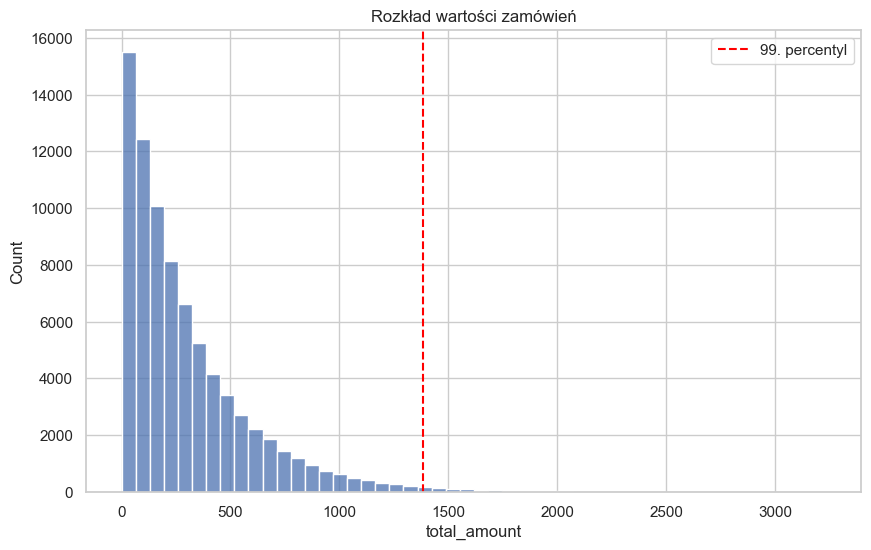

In [6]:
aov = orders["total_amount"].mean()
median = orders["total_amount"].median()
p99 = orders["total_amount"].quantile(0.99)

print("Średnia wartość zamówienia:", round(aov, 2))
print("Mediana:", round(median, 2))
print("99. percentyl:", round(p99, 2))

sns.histplot(orders["total_amount"], bins=50, kde=False)
plt.axvline(p99, color="red", linestyle="--", label="99. percentyl")
plt.legend()
plt.title("Rozkład wartości zamówień")
plt.show()


### Wnioski
- AOV = 301 zł, mediana = 208 zł.
- Outliery są naturalne w danych e-commerce.


## Analiza sezonowości
Badamy trendy miesięczne na podstawie kolumny `order_date`.


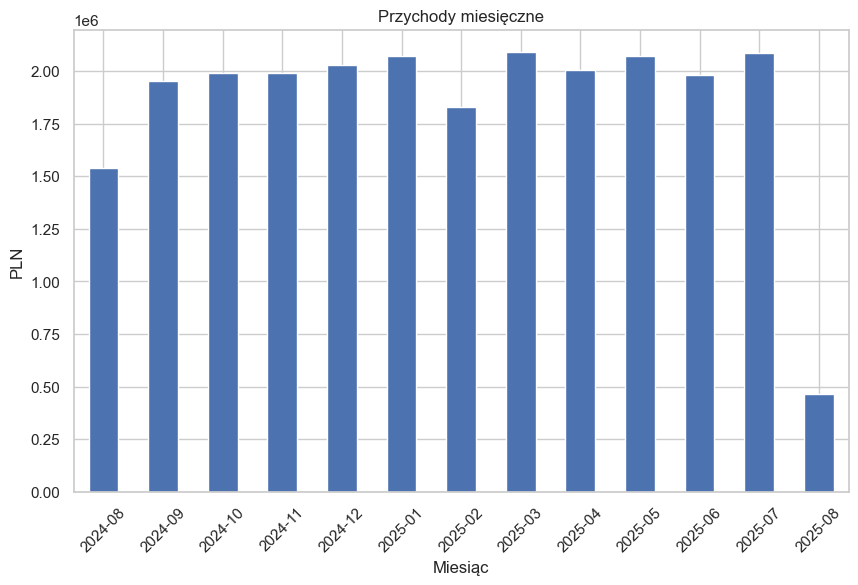

In [7]:
orders["order_date"] = pd.to_datetime(orders["order_date"])
monthly = orders.groupby(orders["order_date"].dt.to_period("M"))["total_amount"].sum()

monthly.plot(kind="bar")
plt.title("Przychody miesięczne")
plt.ylabel("PLN")
plt.xlabel("Miesiąc")
plt.xticks(rotation=45)
plt.show()


### Wnioski
- Widoczna sezonowość.


## Analiza produktów i sprzedawców
Przychód z produkt/seller nie jest możliwe. Analizujemy ilość sprzedaży (quantity).


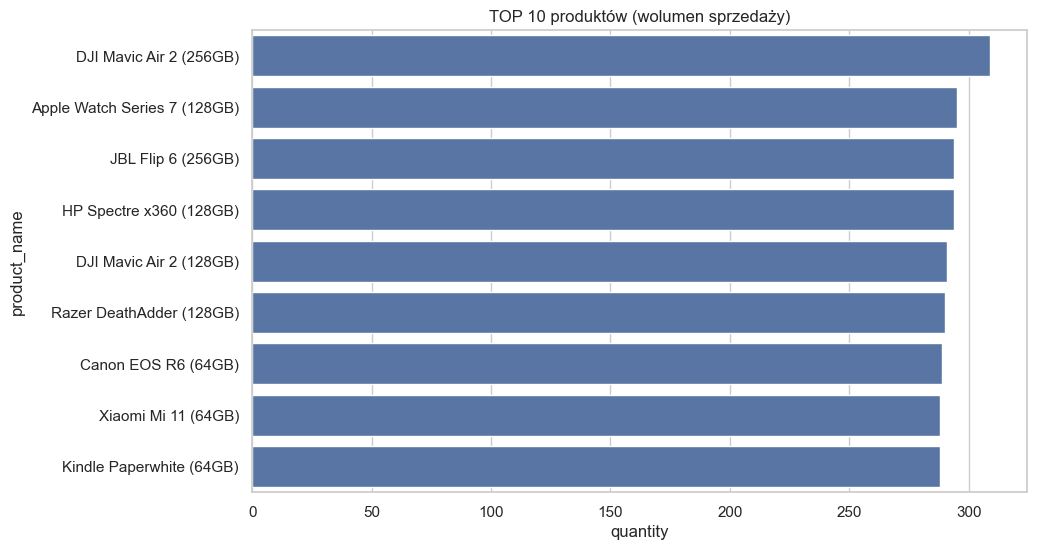

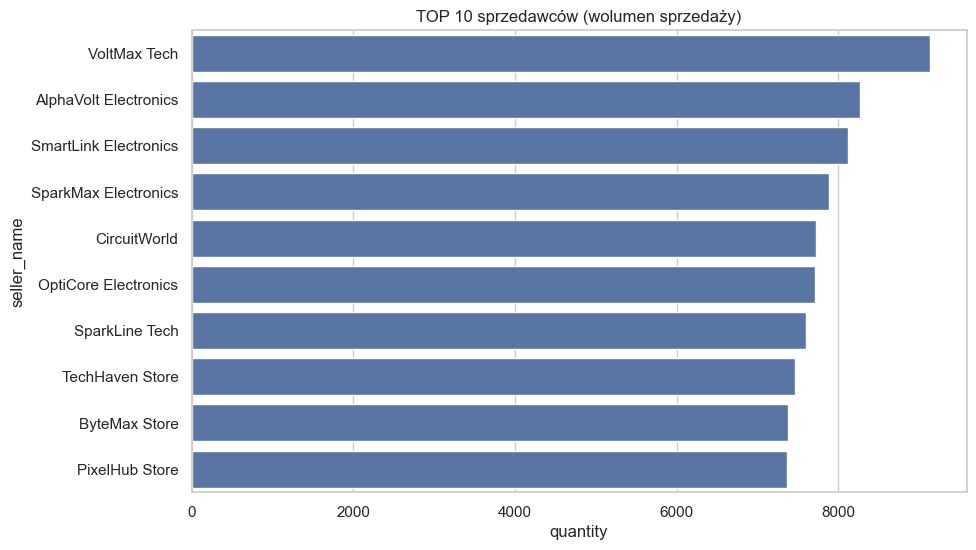

In [8]:
# Top produkty
top_products = order_items.groupby("product_id")["quantity"].sum().nlargest(10).reset_index()
top_products = top_products.merge(products[["product_id", "product_name"]], on="product_id")

sns.barplot(x="quantity", y="product_name", data=top_products)
plt.title("TOP 10 produktów (wolumen sprzedaży)")
plt.show()

# Top sprzedawcy
merged = order_items.merge(products, on="product_id")
top_sellers = merged.groupby("seller_id")["quantity"].sum().nlargest(10).reset_index()
top_sellers = top_sellers.merge(sellers, on="seller_id")

sns.barplot(x="quantity", y="seller_name", data=top_sellers)
plt.title("TOP 10 sprzedawców (wolumen sprzedaży)")
plt.show()


### Wnioski
- Najpopularniejsze produkty i sprzedawcy dominują sprzedaż.  
- Brak możliwości raportowania przychodu per seller/product.  


## Podsumowanie
- Dane są kompletne i spójne (poza `order_items.line_total`).  
- Przychód należy liczyć wyłącznie z `orders.total_amount`.  
- Możemy analizować AOV, sezonowość i ilość sprzedaży.  
- Brak możliwości raportowania marżowości i rentowności per produkt/sprzedawca.  
